<h1><center>Generative Adversarial Network Kaggle Mini-Project</center></h1>
<h2><center>Introduction to Deep Learning</center></h2>
<h3><center>DTSA-5511</center></h3>
<h3><center>University of Colorado Boulder</center></h3>
<h3><center>D. Stephen Haynes</center></h3>

# I’m Something of a Painter Myself
This project aims to build a Generative Adversarial Network (GAN) model that can fool itself. Using multiple neural networks, we will train a model that will modify real photos into an image that resembles a Monet painting.This project aims to build a Generative Adversarial Network model that can fool itself. Using multiple neural networks, we will train a model that will modify real photos into an image that resembles a Monet painting.
- The details and datasets related to this competition are available here: https://www.kaggle.com/competitions/gan-getting-started

- The code below will perform the following:
    - Import the appropriate libraries for image processing and model development
    - Define image processing functions to decode JPEG images and resize them
    - Load the Monet and Photo datasets and prepare for batch processing
    - Define custom layers and model blocks 
    - Define Generator and Discriminator architecture
    - Build CycleGAN architecture
    - Train the CycleGAN  Model
    - Using the trained model, process the Photos into Monet-like images and archive the images into a zip file
  
- The file will be submitted to the Kaggle competition for evaluation and ranking once complete

## Generative Adversarial Network (GAN)
Generative Adversarial Networks (GANs) are a class of artificial intelligence algorithms used in unsupervised machine learning, implemented by two neural networks contesting each other in a zero-sum game framework. This setup allows them to generate new data with the same statistics as a training set.
GANs are comprised of two primary components: a Generator and a Discriminator. The Generator creates new data instances, taking a random noise vector as input and outputting data to mimic actual data in distribution and features. The Discriminator evaluates the authenticity of the data received from the Generator and classifies whether that instance is from the training set (real) or data created by the Generator (fake). During this process, the Generator learns to produce more realistic data over time while the Discriminator learns to better distinguish between real and fake data.
This project will use a specific type of GAN known as a CycleGAN. CycleGANs are particularly useful for image-to-image translation tasks where paired examples are unavailable. This function can be used to enhance raw medical images into more detailed ones for better diagnosis, or it can be used to transform standard photos into enhanced ones in a style resembling famous artists’ paintings (such as Monet).


## The Dataset
- The data from the Kaggle Competition contains 300 images of Monet paintings and over 7,000 images of Photos of landscapes, nature, and other general scenery.
- For this project, the Monet images will be the input for the Generator to learn how to convert the Photos into a Monet-like style.
- The core of this code is built off of Amy Jang's Monet CycleGAN Tutorial available here: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
- The code below will load the data and output initial details of the datasets before evaluation.

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, optimizers
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
import PIL


AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2024-06-23 15:57:45.906341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 15:57:45.906395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 15:57:45.907897: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [2]:
# Verify GPUs are present for TensorFlow processing
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Ingest files and count number of records in each folder
PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
MONET_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')

# Exploratory Data Analysis (EDA)
- As a well-established Kaggle Competition, there isn’t much to explore that hasn’t already been identified. However, we will check the number of files in each directory and the total number of images in those files and then load some sample images to visualize the style of the photos and Monet paintings included in the provided data.

In [4]:
def print_large_text(text, size=4):
    display(HTML(f"<h{size}>{text}</h{size}>"))


photo_count = len(PHOTO_FILENAMES)
monet_count = len(MONET_FILENAMES)

print_large_text(f'Photo TFRecord Files: {photo_count}', size=3)
print_large_text(f'Monet TFRecord Files: {monet_count}', size=3)

In [5]:
def count_records_in_tfrecord(file_path):
    # Create a dataset from the TFRecord file
    dataset = tf.data.TFRecordDataset(file_path)
    # Count the number of records by iterating through the dataset
    return sum(1 for _ in dataset)

# Calculate total number of images in Photo TFRecord files
photo_image_count = sum(count_records_in_tfrecord(file) for file in PHOTO_FILENAMES)
print_large_text(f'Total Photo images: {photo_image_count}', size=3)

# Calculate total number of images in Monet TFRecord files
monet_image_count = sum(count_records_in_tfrecord(file) for file in MONET_FILENAMES)
print_large_text(f'Total Monet images: {monet_image_count}', size=3)

In [6]:
# Function to translate tfrec to jpeg
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    resize_shape = tf.constant([256, 256], dtype=tf.int32)
    image = tf.image.resize(image, resize_shape)  # Use the explicitly defined resize_shape
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

# Extract image and preprocess
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [7]:
# Define function to load image datasets from TFRecord files
def load_dataset(filenames, labeled=True, shuffle=True, buffer_size=1000):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    return dataset

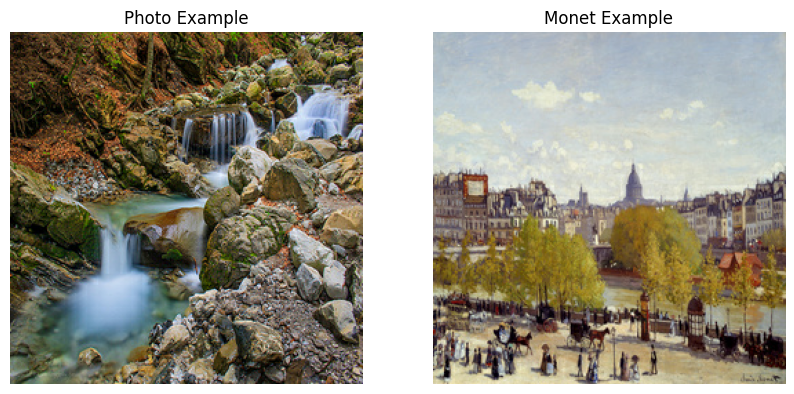

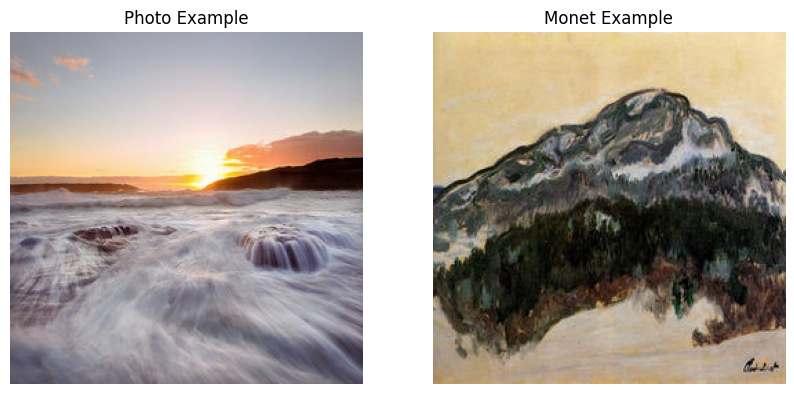

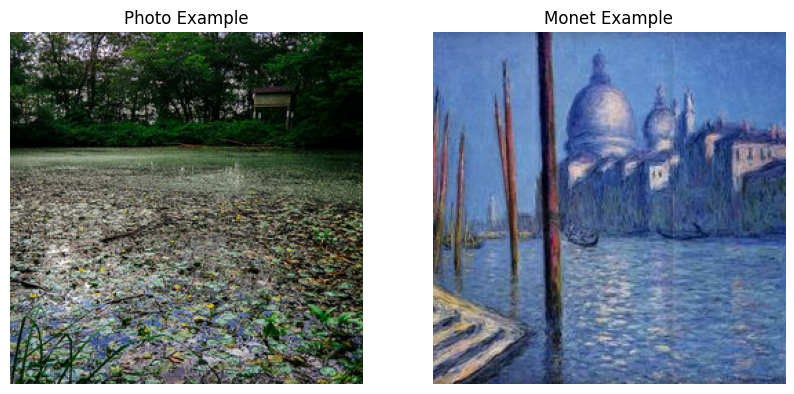

In [8]:
# Load datasets
monet_ds = load_dataset(MONET_FILENAMES, labeled=True, shuffle=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True, shuffle=True).batch(1)

# Fetch an example from each dataset
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Photo Example')
plt.imshow(example_photo[0] * 0.5 + 0.5)  # Rescaling back to [0,1]
plt.axis('off')  # Hide axes for better visualization

plt.subplot(122)
plt.title('Monet Example')
plt.imshow(example_monet[0] * 0.5 + 0.5)  # Rescaling back to [0,1]
plt.axis('off')  # Hide axes for better visualization

plt.show()

# Fetch an example from each dataset
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Photo Example')
plt.imshow(example_photo[0] * 0.5 + 0.5)  # Rescaling back to [0,1]
plt.axis('off')  # Hide axes for better visualization

plt.subplot(122)
plt.title('Monet Example')
plt.imshow(example_monet[0] * 0.5 + 0.5)  # Rescaling back to [0,1]
plt.axis('off')  # Hide axes for better visualization

plt.show()

# Fetch an example from each dataset
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Photo Example')
plt.imshow(example_photo[0] * 0.5 + 0.5)  # Rescaling back to [0,1]
plt.axis('off')  # Hide axes for better visualization

plt.subplot(122)
plt.title('Monet Example')
plt.imshow(example_monet[0] * 0.5 + 0.5)  # Rescaling back to [0,1]
plt.axis('off')  # Hide axes for better visualization

plt.show()

## EDA Results
- Above, we can see that the photos generally depict landscapes or nature subjects. The Monet images are similar, as Monet was known to use his immediate surroundings as subjects for his paintings.

# Model Architecture
- There are a variety of components that we will use to build our CycleGAN Architecture, including:
    - Instance Normalization: used for stabilizing the training during transfer tasks
    - Downsample: defines blocks for convolution within the Generator, applying instance normalization and activation functions
    - Upsample: defines blocks for transposed convolution to be used in the Generator, applying instance normalization and activation functions
    - Generator: construct a U-Net architecture that transforms images from one domain to another (Monet to Photo or Photo to Monet)
    - Discriminator: build a simple convolution network that classifies images as real or generated
- These components will be loaded into the CycleGAN architecture, and then we will:
    - Instantiate CycleGAN Components: create the generators and discriminators for both Monet and Photo styles and provide summaries of their architectures
    - Instantiate CycleGAN Model: set up CycleGAN with specified lambda parameters for cycle consistency loss and identity loss, which is crucial for effective style transfer
    - Compile CycleGAN Model: define optimizers and loss functions for training the model
    - Train the CycleGAN Model
- Once model training is complete, we will use the Monet Generator to convert real photos to a Monet style. Then, we will visualize some results and export the generated images into a .zip file for submission to the Kaggle competition.

In [9]:
# Define InstanceNormalizaion class to stabilize transfers
class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

    def __init__(self, epsilon=1e-5, gamma_initializer='ones'):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
        self.gamma_initializer = gamma_initializer

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=self.gamma_initializer,
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [10]:
# Define class to introduce noise into images
class NoiseLayer(layers.Layer):
    def __init__(self, stddev=0.1, **kwargs):
        super(NoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
        return inputs + noise

In [11]:
# Downsamples an input using Conv2D followed by optional Instance Normalization and noise addition
def downsample(filters, size, apply_instancenorm=True, add_noise=False, noise_stddev=0.1):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = tf.keras.Sequential()
    block.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        block.add(InstanceNormalization(gamma_initializer=gamma_init))
    
    if add_noise:
        block.add(NoiseLayer(stddev=noise_stddev))

    block.add(layers.LeakyReLU())
    
    return block

# Upsamples an input using Conv2DTranspose followed by Instance Normalization
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = tf.keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, size, strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     use_bias=False))

    block.add(InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        block.add(layers.Dropout(0.5))

    block.add(layers.ReLU())

    return block

In [12]:
# U-Net architecture to downsample and upsample each image
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        print("Downsample shape:", x.shape)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        print("Upsample shape:", x.shape, "Skip shape:", skip.shape)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [13]:
# Define discriminator that will evaluate images
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = InstanceNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return Model(inputs=inp, outputs=last)

## CycleGAN Architecture
- The CycleGAN class defined below is the heart of this code that performs the image-to-image translation work.
- The architecture of the CycleGAN is described here:
    - Two Generators (G and F):
        - G: Translates from domain X (regular photos) to domain Y (Monet-style paintings)
        - F: Translates from domain Y to X
    - Two Discriminators (D_X and D_Y):
        - D_X: Distinguishes between images from domain X (photos) and translated images by F
        - D_Y: Distinguishes between images from domain Y (Monet paintings) and translated images by G
    - Cycle Consistency Loss: This ensures that translating an image to another domain and back again maintains key attributes and structure.

In [14]:
# Define CycleGAN
class CycleGAN(tf.keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10.0, lambda_identity=0.5):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Monet-to-photo -> photo-to-Monet
            fake_photo = self.m_gen(real_monet, training=True)
            cycled_monet = self.p_gen(fake_photo, training=True)

            # Photo-to-Monet -> Monet-to-photo
            fake_monet = self.p_gen(real_photo, training=True)
            cycled_photo = self.m_gen(fake_monet, training=True)

            # Identity mapping
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator output
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)

            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Calculate loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

            cycle_monet_loss = self.cycle_loss_fn(real_monet, cycled_monet)
            cycle_photo_loss = self.cycle_loss_fn(real_photo, cycled_photo)

            total_cycle_loss = cycle_monet_loss + cycle_photo_loss

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet) * self.lambda_identity
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo) * self.lambda_identity

        # Calculate gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply gradients
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


## Loss Functions
- The loss functions below are a vital component to generating realistic images.
    - Generator Loss: Measures how well the Generator can trick the Discriminator into detecting the generated images as real
    - Discriminator Loss: Measures how well the Discriminator distinguishes between real and generated images
    - Calc Cycle Loss: Ensures that the transformed input image remains the same as the original using mean absolute error between the original and cycled image
    - Identity Loss: Preserves the color composition and overall structure of an image that is not supposed to change, such as a Monet painting passed through the Monet Generator

In [15]:
def generator_loss(disc_generated_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss


In [16]:
# Instantiate Generators and Discriminators
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

Downsample shape: (None, 128, 128, 64)
Downsample shape: (None, 64, 64, 128)
Downsample shape: (None, 32, 32, 256)
Downsample shape: (None, 16, 16, 512)
Downsample shape: (None, 8, 8, 512)
Downsample shape: (None, 4, 4, 512)
Downsample shape: (None, 2, 2, 512)
Downsample shape: (None, 1, 1, 512)
Upsample shape: (None, 2, 2, 512) Skip shape: (None, 2, 2, 512)
Upsample shape: (None, 4, 4, 512) Skip shape: (None, 4, 4, 512)
Upsample shape: (None, 8, 8, 512) Skip shape: (None, 8, 8, 512)
Upsample shape: (None, 16, 16, 512) Skip shape: (None, 16, 16, 512)
Upsample shape: (None, 32, 32, 256) Skip shape: (None, 32, 32, 256)
Upsample shape: (None, 64, 64, 128) Skip shape: (None, 64, 64, 128)
Upsample shape: (None, 128, 128, 64) Skip shape: (None, 128, 128, 64)
Downsample shape: (None, 128, 128, 64)
Downsample shape: (None, 64, 64, 128)
Downsample shape: (None, 32, 32, 256)
Downsample shape: (None, 16, 16, 512)
Downsample shape: (None, 8, 8, 512)
Downsample shape: (None, 4, 4, 512)
Downsample s

## Model Structure
- Below, we will view our final model structure for the Monet Generator and Discriminator.

In [17]:
# Summary of Monet Generator
monet_generator.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,328 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    524,800 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,098,176 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,195,328 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,195,328 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,195,328 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,389,632 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,389,632 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Summary of Monet Discriminator
monet_discriminator.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_30       │ (None, 31, 31, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

## Pre-test
- The pre-tests below are just to ensure that the Generator functions work. The second image in each plot is expected to be gray as the generators have not yet been trained.

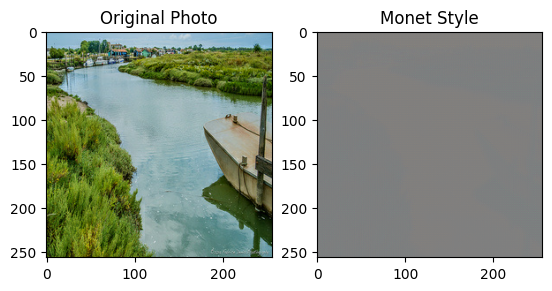

In [19]:
# Pre-test transformation of Photo to Monet functions
example_photo = next(iter(photo_ds))

to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet Style")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

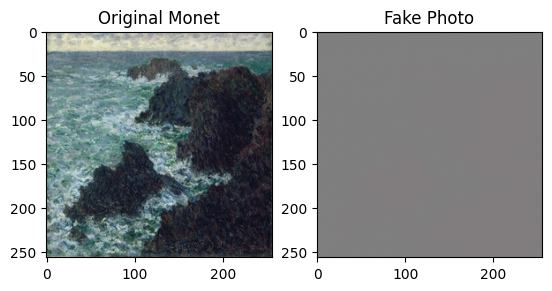

In [20]:
# Pre-test transformation of Monet to Photo functions
example_monet = next(iter(monet_ds))

to_photo = photo_generator(example_monet)

plt.subplot(1, 2, 1)
plt.title("Original Monet")
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Fake Photo")
plt.imshow(to_photo[0] * 0.5 + 0.5)
plt.show()

## Model Training
- Below, we set the final parameters and train the model.

In [21]:
# Set hyperparameters
LAMBDA_CYCLE = 10
LAMBDA_ID = 0.5

# Instantiate the CycleGAN model
cycle_gan_model = CycleGAN(
    monet_generator=monet_generator,
    photo_generator=photo_generator,
    monet_discriminator=monet_discriminator,
    photo_discriminator=photo_discriminator,
    lambda_cycle=LAMBDA_CYCLE,
    lambda_identity=LAMBDA_ID
)

# Define the optimizers
m_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
p_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
m_disc_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
p_disc_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Compile the model
cycle_gan_model.compile(
    m_gen_optimizer=m_gen_optimizer,
    p_gen_optimizer=p_gen_optimizer,
    m_disc_optimizer=m_disc_optimizer,
    p_disc_optimizer=p_disc_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)


In [22]:
# Train the CycleGAN model
cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=25)

Epoch 1/25


I0000 00:00:1719158396.628886     519 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 176s 196ms/step - monet_disc_loss: 0.7618 - monet_gen_loss: 2.4061 - photo_disc_loss: 1.0245 - photo_gen_loss: 1.7505
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - monet_disc_loss: 0.2706 - monet_gen_loss: 3.5548 - photo_disc_loss: 0.3232 - photo_gen_loss: 3.1389
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 195ms/step - monet_disc_loss: 0.1246 - monet_gen_loss: 4.6171 - photo_disc_loss: 0.2204 - photo_gen_loss: 3.9466
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 193ms/step - monet_disc_loss: 0.2099 - monet_gen_loss: 4.7312 - photo_disc_loss: 0.1744 - photo_gen_loss: 4.3880
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - monet_disc_loss: 0.1328 - monet_gen_loss: 5.2232 - photo_disc_loss: 0.1184 - photo_gen_loss: 4.7131
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - monet_disc_loss: 0.2136 - monet_gen_loss: 5.0006 - photo_disc_loss: 0.0465 - photo_gen_loss: 5.3458
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 193ms/step - monet_disc_loss: 0.0832 - monet_gen_loss: 5.5844 - photo_disc_loss: 0.1271 - photo_gen_loss: 5.2021
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - monet_disc_l

## Visual Check
- We'll plot some of the Photo to Monet and Monet to Photo conversions to visualize our results.

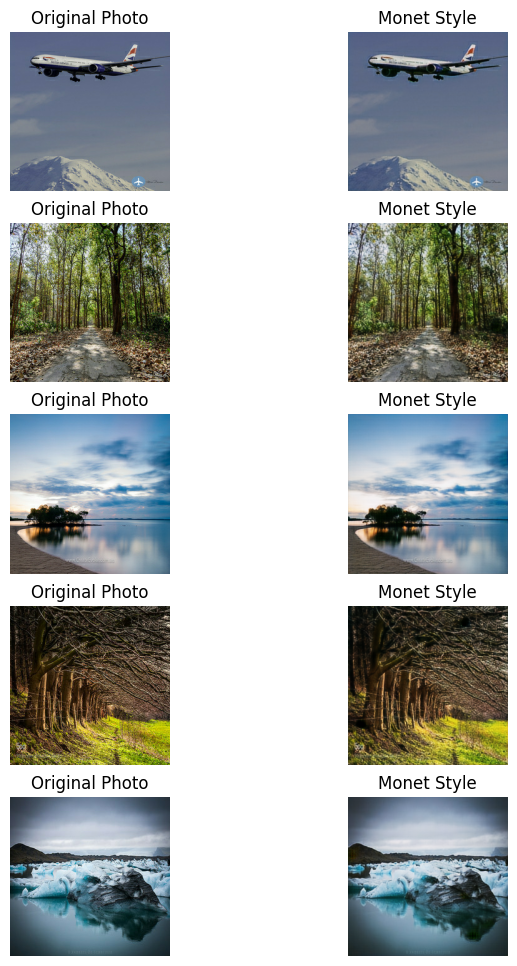

In [23]:
# Display some of the Photo to Monet conversions
_, ax = plt.subplots(5, 2, figsize=(8, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Original Photo")
    ax[i, 1].set_title("Monet Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

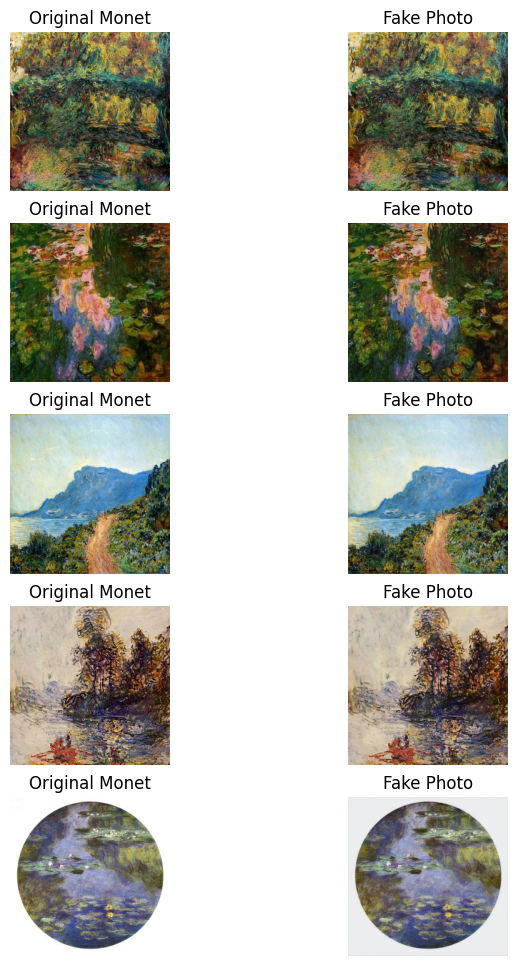

In [24]:
# Display some of the Monet to Photo conversions
_, ax = plt.subplots(5, 2, figsize=(8, 12))
for i, img in enumerate(monet_ds.take(5)):
    prediction = photo_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Original Monet")
    ax[i, 1].set_title("Fake Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Convert and Export Images
- All that's left to do is convert all of the photo images to Monet Style and archive them in a .zip to submit to the competition.

In [25]:
# Iterate through each photo and convert to Monet Style using trained model
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")    

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


'/kaggle/working/images.zip'

# Results and Analysis
- This project is a great example of where art and (data) science meet. This code has no numeric metrics to measure the success of creating fake Monet-style images, so the viewer must initially judge for themselves. That said, I scored 77.83 in the Kaggle competition, which nearly put me in the top 50 for this round of scoring.

# Conclusion
- Generative Adversarial Networks (GANs) are an incredibly powerful tool for modifying images. By iteratively challenging their own algorithms, GANs can imprint one image style on to another. Who knew there was a way to make a computer fight with itself?
- Here are a couple of my findings:
    - Doubling the number of epochs of my original model from 25 to 50 improved the Kaggle score, if only slightly. This longer training time suggests that even more time iterating through the CycleGAN would yield better results.
    - Adding noise to the downsampling structure worsened the score, showing that influencing the original image with outside data may not be ideal.
- Future ideas and improvements:
    - Monet’s painting style could be described as a slightly out-of-focus portrait of the world. Because of this, the similarities between the photos and paintings made for an easy transfer of style in this project.
    - I want to experiment with CycleGANs using more extreme artist styles, like Picasso’s, to see what kind of output a similar architecture would create.

## Reference

[1] I'm Something of a Painter Myself
- Amy Jang, Ana Sofia Uzsoy, Phil Culliton
- "I'm Something of a Painter Myself," 2020
- https://www.kaggle.com/competitions/gan-getting-started

[2] Monet CycleGAN Tutorial
- Amy Jang
- "Monet CycleGAN Tutorial," 2020
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial